## model try


### Load libraries

In [1]:
import cv2
import os
import json
import time

import pathlib
from torch.utils.data import DataLoader
import sys
sys.path.append('../')
from src.data.my_rpg_dataset import XRayDataSet_windows
from src.data.my_rpg_dataset import XRayDataSet_windows_transform
from src.data.my_rpg_dataset import collate_fn
from tqdm import tqdm

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.faster_rcnn import *
import torch
import albumentations as A

In [2]:
print(os.getcwd())  

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


## Real try of the Model

In [3]:
# train on the GPU or on the CPU, if a GPU is not available
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [4]:
#keep only predictions with score higher than the threshold
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [15]:
#load test data
test_dataset = XRayDataSet_windows(pathlib.Path('../literature/Other/supervisely/wrist/test_pickles'))
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0,collate_fn=collate_fn)

In [5]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img,cmap='gray')
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx].detach().numpy()

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [16]:
iteration =  iter(test_dataloader)

In [139]:
images , targets = next(iteration)

In [101]:
images[0].shape

torch.Size([3, 976, 353])

In [102]:
targets[0]['labels'].detach().cpu().numpy()

array([2], dtype=int64)

In [140]:
transform = A.Compose([
        A.HorizontalFlip(always_apply=True,p=0.5),
        A.RandomBrightnessContrast(always_apply=True,p=0.2,brightness_limit=(-0.3, -0.2), contrast_limit=(0.8, 1.0)),
        A.Sharpen(always_apply=True)
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))

In [141]:
import numpy as np

img_np = images[0].permute(1, 2, 0).detach().cpu().numpy()

# Convert the array to a cv2 format
img_cv2 = cv2.cvtColor(np.uint8(img_np*255), cv2.COLOR_BGR2RGB)

In [142]:
transformed = transform(image=img_cv2, bboxes=targets[0]['boxes'].detach().cpu().numpy(), class_labels=targets[0]['labels'].detach().cpu().numpy())

In [143]:
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']

In [6]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White
category_id_to_name = {2: 'text', 1: 'fracture'}
from matplotlib import pyplot as plt


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    xmin, ymin, xmax, ymax = bbox  # extract coordinates
    w, h = xmax - xmin, ymax - ymin  # calculate width and height
    bbox_new = [xmin, ymin, w, h]
    x_min, y_min, w, h = bbox_new
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

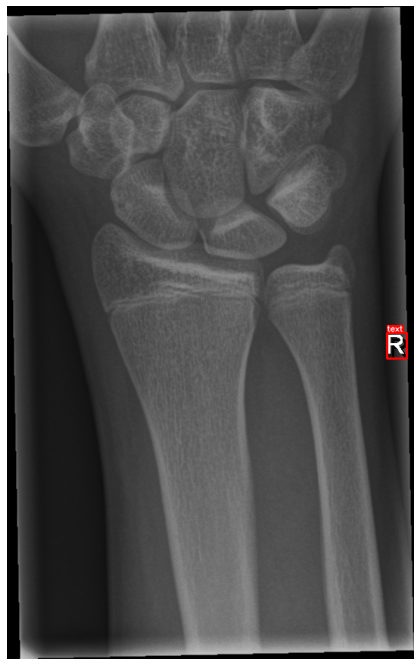

In [145]:
#ORIGINAL
visualize(
    img_cv2,
    targets[0]['boxes'].detach().cpu().numpy(),
    targets[0]['labels'].detach().cpu().numpy(),
    category_id_to_name,
)

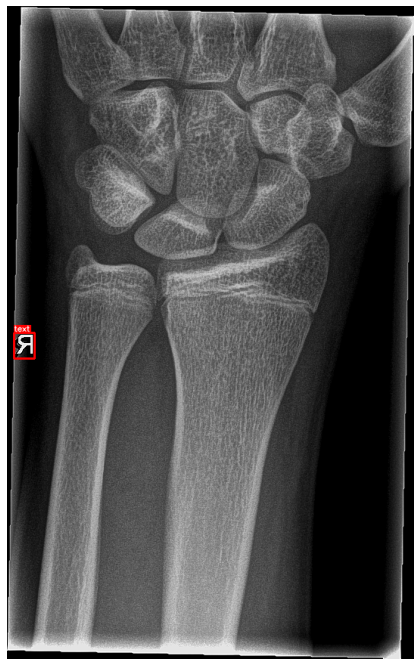

In [146]:
#AUGMENTED
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['class_labels'],
    category_id_to_name,
)

## Go to the training data and create more with augmnentation


import the training json file in coco format to make sure that i am only working with the training data


In [1]:
import json

# Load the JSON file as a dictionary
with open('../data/train_coco_data.json', 'r') as f:
    data = json.load(f)

# Extract the file_names from the "images" key
file_names = [img['file_name'] for img in data['images']]

# Print the list of file_names
print(file_names)

['../literature/Other/supervisely/wrist/rpg_images/0001_1297860395_01_WRI-L1_M014.png', '../literature/Other/supervisely/wrist/rpg_images/0001_1297860435_01_WRI-L2_M014.png', '../literature/Other/supervisely/wrist/rpg_images/0002_0354485759_01_WRI-R2_F012.png', '../literature/Other/supervisely/wrist/rpg_images/0002_0354485735_01_WRI-R1_F012.png', '../literature/Other/supervisely/wrist/rpg_images/0003_0663715782_02_WRI-R2_M011.png', '../literature/Other/supervisely/wrist/rpg_images/0003_0662359226_01_WRI-R1_M011.png', '../literature/Other/supervisely/wrist/rpg_images/0003_0664918633_03_WRI-R1_M011.png', '../literature/Other/supervisely/wrist/rpg_images/0003_0663715732_02_WRI-R1_M011.png', '../literature/Other/supervisely/wrist/rpg_images/0003_0664918693_03_WRI-R2_M011.png', '../literature/Other/supervisely/wrist/rpg_images/0003_0662359351_01_WRI-R2_M011.png', '../literature/Other/supervisely/wrist/rpg_images/0004_0542630513_01_WRI-L2_M003.png', '../literature/Other/supervisely/wrist/rpg

In [2]:
file_names = [path.replace('.png', '.pickle') for path in file_names]
file_names = [path.replace('rpg_images', 'train_pickles_new') for path in file_names]

In [12]:
file_names

['../literature/Other/supervisely/wrist/train_pickles_new/0001_1297860395_01_WRI-L1_M014.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0001_1297860435_01_WRI-L2_M014.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0002_0354485759_01_WRI-R2_F012.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0002_0354485735_01_WRI-R1_F012.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0003_0663715782_02_WRI-R2_M011.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0003_0662359226_01_WRI-R1_M011.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0003_0664918633_03_WRI-R1_M011.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0003_0663715732_02_WRI-R1_M011.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0003_0664918693_03_WRI-R2_M011.pickle',
 '../literature/Other/supervisely/wrist/train_pickles_new/0003_0662359351_01_WRI-R2_M011.pickle',
 '../literature/Othe

In [39]:
import pickle

# Open the pickle file in read-binary mode

with open('../literature/Other/supervisely/wrist/train_pickles_new/0001_1297860395_01_WRI-L1_M014.pickle', 'rb') as f:
    # Load the contents of the pickle file
    data = pickle.load(f)

# Now you can use the 'data' variable to access the contents of the pickle file
print(data)

{'image': '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0001_1297860395_01_WRI-L1_M014.png', 'target': {'boxes': tensor([[  1., 577.,  55., 641.]]), 'labels': tensor([2]), 'image_id': tensor([0]), 'area': tensor([3456])}}


In [59]:
from tqdm import tqdm
import pickle
def augment_data(pickle_list):
    i = len(pickle_list) 

    transform = A.Compose([
        A.HorizontalFlip(always_apply=True,p=0.5),
        A.RandomBrightnessContrast(always_apply=True,p=0.2,brightness_limit=(-0.3, -0.2), contrast_limit=(0.8, 1.0)),
        A.Sharpen(always_apply=True,alpha=(0.8, 1.0))
    ], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))
    
    for list in pickle_list:
        

        with open(list, 'rb') as f:
            # Load the contents of the pickle file
            data = pickle.load(f)
            
        img_path = data['image']
        Image = cv2.imread(img_path)
        target = data['target']
        transformed = transform(image=Image, bboxes=target['boxes'].detach().cpu().numpy(), class_labels=target['labels'].detach().cpu().numpy())

        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']
        transformed_class_labels = transformed['class_labels']

        d = {}

        boxes = torch.FloatTensor(transformed_bboxes)
        labels = torch.as_tensor(transformed_class_labels, dtype=torch.int64)
        i = i + 1
        image_id = torch.tensor([i])
                
        
        d["boxes"] = boxes
        d["labels"] = labels
        d["image_id"] = image_id

        

        target = d

        #fix the file name 
        # split the path into directory and filename
        dir_path, filename = img_path.rsplit('\\', 1)

        # split the filename into name and extension
        name, ext = filename.rsplit('.', 1)

        # add a counter before the extension
        new_filename = f"{name}_{i}.{ext}"

        # join the directory and the new filename
        new_path = f"{dir_path}\\{new_filename}"
        
        img = new_path

        ready_data = {'image' : img,'target' : target}

        # Save the image in PNG format
        cv2.imwrite(new_path, transformed_image)

        # split the path into directory and filename
        dir_path, filename = list.rsplit('/', 1)

        # split the filename into name and extension
        name, ext = filename.rsplit('.', 1)

        # add a counter before the extension
        new_filename = f"{name}_{5}.{ext}"

        # join the directory and the new filename
        new_path = f"{dir_path}/{new_filename}"

        #save the pickle file
        with open(new_path, 'wb') as file:
            # Save the object to the file using pickle.dump()
            pickle.dump(ready_data, file)

        if i == 15213 : break


    return ready_data

In [67]:
for list in file_names:
    list
    break

In [68]:
list

'../literature/Other/supervisely/wrist/train_pickles_new/0001_1297860395_01_WRI-L1_M014.pickle'

In [73]:
# split the path into directory and filename
dir_path, filename = list.rsplit('/', 1)

# split the filename into name and extension
name, ext = filename.rsplit('.', 1)

# add a counter before the extension
new_filename = f"{name}_{5}.{ext}"

# join the directory and the new filename
new_path = f"{dir_path}/{new_filename}"

In [74]:
new_path

'../literature/Other/supervisely/wrist/train_pickles_new/0001_1297860395_01_WRI-L1_M014_5.pickle'

In [60]:
aug = augment_data(file_names)

In [61]:
aug

{'image': '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0001_1297860395_01_WRI-L1_M014_15213.png',
 'target': {'boxes': tensor([[439., 577., 493., 641.]]),
  'labels': tensor([2]),
  'image_id': tensor([15213])}}

In [62]:
data

{'image': '..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0001_1297860395_01_WRI-L1_M014.png',
 'target': {'boxes': tensor([[  1., 577.,  55., 641.]]),
  'labels': tensor([2]),
  'image_id': tensor([0]),
  'area': tensor([3456])}}

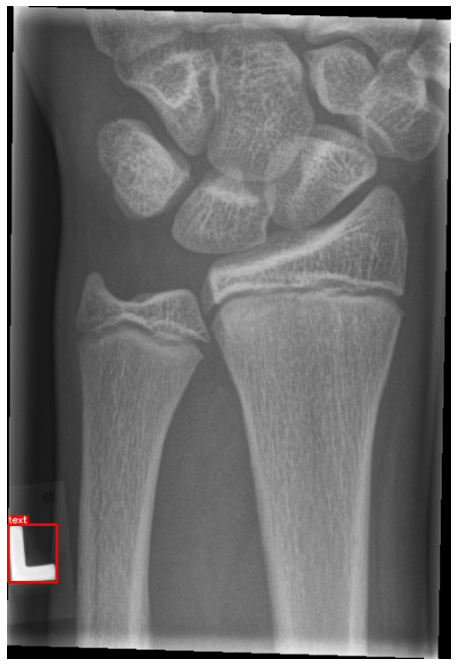

In [63]:
#ORIGINAL
img_path = data['image']
img = cv2.imread(img_path)
visualize(
    img,
    data['target']['boxes'].detach().cpu().numpy(),
    data['target']['labels'].detach().cpu().numpy(),
    category_id_to_name,
)

In [64]:
img_path

'..\\literature\\Other\\supervisely\\wrist\\rpg_images\\0001_1297860395_01_WRI-L1_M014.png'

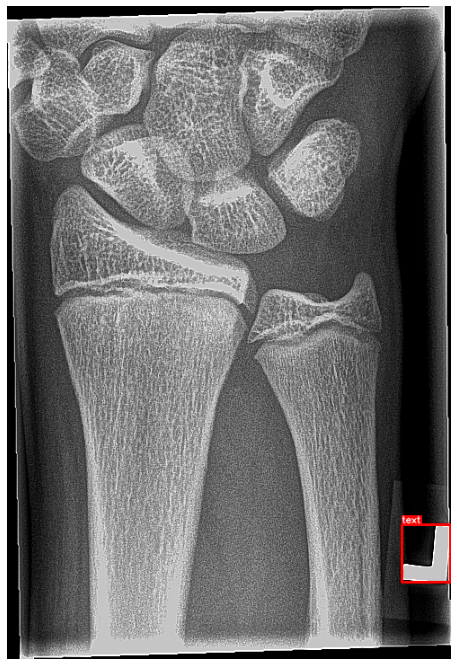

In [65]:
img_path = aug['image']
img = cv2.imread(img_path)
visualize(
    img,
    aug['target']['boxes'].detach().cpu().numpy(),
    aug['target']['labels'].detach().cpu().numpy(),
    category_id_to_name,
)

load through the new loader


In [22]:
transform = A.Compose([
        A.HorizontalFlip(always_apply=False,p=0.5),
        A.RandomBrightnessContrast(always_apply=False,p=0.5,brightness_limit=(-0.3, -0.2), contrast_limit=(0.8, 1.0)),
        A.Sharpen(always_apply=False,p=0.5,alpha=(0.8, 1.0))
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))

In [23]:
#load test data
test_dataset = XRayDataSet_windows_transform(pathlib.Path('../literature/Other/supervisely/wrist/test_pickles'),transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0,collate_fn=collate_fn)

In [24]:
iteration =  iter(test_dataloader)

In [40]:
images , targets = next(iteration)

In [41]:
import numpy as np

img_np = images[0].permute(1, 2, 0).detach().cpu().numpy()

# Convert the array to a cv2 format
img_cv2 = cv2.cvtColor(np.uint8(img_np*255), cv2.COLOR_BGR2RGB)

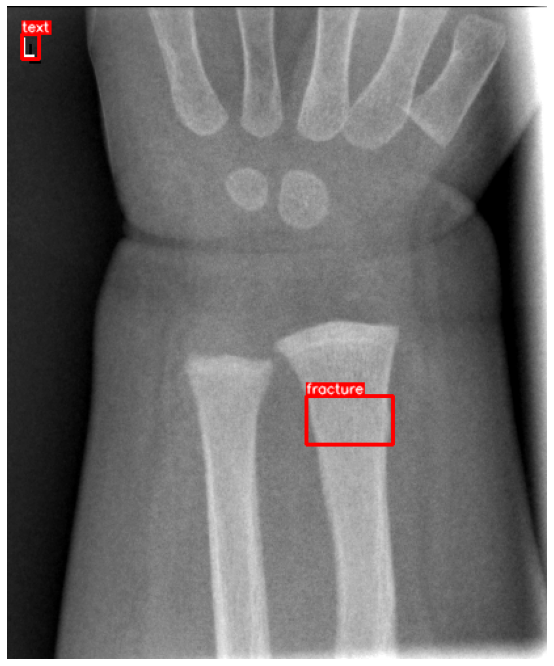

In [42]:
#ORIGINAL
visualize(
    img_cv2,
    targets[0]['boxes'].detach().cpu().numpy(),
    targets[0]['labels'].detach().cpu().numpy(),
    category_id_to_name,
)